$$\Huge\textbf{Image Classification with CNN}$$

# Imports

In [2]:
# standard library imports
import os  # Directory and file operations
import time
import shutil

# installed library imports
import csv  # For saving results
import matplotlib.pyplot as plt  # Plotting library
import numpy as np
from PIL import Image  # For image loading and preprocessing
import torch  # PyTorch main library
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
from torchsummary import summary  # Model summary utility
import torch.utils.data as data  # Data handling utilities
import torchvision.transforms as transforms  # Transformations for image preprocessing
import torchvision.datasets as datasets  # Standard datasets
from torch.utils.data import DataLoader  # Data loading utilities
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc  # Performance metrics


from torchsummary import summary
from random import sample

# Global Constants

In [3]:
# Directories
TRAIN_DIR = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_dataset\processed_data\without_cross_validation\train'
VAL_DIR = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_dataset\processed_data\without_cross_validation\validation'
TEST_DIR = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_dataset\processed_data\without_cross_validation\test'
OUTPUT_DIR = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_output\cnn'
RESULTS_DIR = os.path.join(OUTPUT_DIR, 'results')
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')

In [4]:
# Create directories if they don't exist
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

In [5]:
# Mean and Standard deviation of the training set 
MEAN = [0.4333, 0.3943, 0.3591]
STD = [0.2445, 0.2401, 0.2347]

In [6]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters

In [7]:
BATCH_SIZE = 64
NUM_EPOCHS = 200
LEARNING_RATE = 0.001
DROPOUT = 0.6

PATIENCE = 25  # Number of epochs the training should continue without improvement in the validation loss before stopping 

NUM_CLASSES = 5
CLASSES = ['airplane_cabin', 'hockey_arena', 'movie_theater', 'staircase', 'supermarket']

# 1. Data Loading and Preprocessing

In [8]:
# Compute the mean and standard deviation of the training set (will be used to normalize train, val and test sets)
def compute_mean_std(dataset):
    """
    Compute the mean and standard deviation of a dataset.

    Inputs:
    - dataset (Dataset): A PyTorch dataset.

    Outputs:
    - mean (list): Mean of the dataset.
    - std (list): Standard deviation of the dataset.
    """
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_samples = images.size(0)  # Batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    mean /= len(dataset)
    std /= len(dataset)
    return mean, std

In [9]:
def get_data_loaders(train_dir, val_dir, test_dir, batch_size=BATCH_SIZE):
    """
    Create data loaders for training, validation, and testing.

    Inputs:
    - train_dir (str): Path to the training data directory.
    - val_dir (str): Path to the validation data directory.
    - test_dir (str): Path to the test data directory.
    - batch_size (int): Batch size for the data loaders.


    Outputs:
    - train_loader, val_loader, test_loader (DataLoader): Data loaders for training, validation, and testing.
    """
    # Initial transform to convert images to tensors
    initial_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # Load datasets with initial transform
    train_dataset = datasets.ImageFolder(root=train_dir, transform=initial_transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=initial_transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=initial_transform)

    # Compute mean and std on the train_dataset
    mean, std = compute_mean_std(train_dataset)

    # Final transform with normalization
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])

    # Reload datasets with final transform
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    # Create DataLoaders for each dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, mean, std

# 2. Model Initialization

## 2.1. Weight Initialization

In [10]:
def weights_init(m):
    """
    Initialize weights with a Gaussian distribution.

    Inputs:
    - m (nn.Module): A neural network module.
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # He initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)  # Initialize bias to 0

## 2.2. CNN Architecture

### 2.2.1. Initial Architecture, 3 Convolutional Layers, All with Padding

In [11]:
"""
CNN Architecture:
- Conv Layer 1: 3 input channels, 32 output channels, kernel size 3x3, stride 1, padding 1
- BatchNorm Layer 1: 32 channels
- ReLU Activation 1
- MaxPool Layer 1: kernel size 2x2, stride 2
- Conv Layer 2: 32 input channels, 64 output channels, kernel size 3x3, stride 1, padding 1
- BatchNorm Layer 2: 64 channels
- ReLU Activation 2
- MaxPool Layer 2: kernel size 2x2, stride 2
- Conv Layer 3: 64 input channels, 128 output channels, kernel size 3x3, stride 1, padding 1
- BatchNorm Layer 3: 128 channels
- ReLU Activation 3
- MaxPool Layer 3: kernel size 2x2, stride 2
- Dropout: 0.5
- Fully Connected Layer 1: 128 * 32 * 32 inputs, 512 outputs
- ReLU Activation 4
- Dropout: 0.5
- Fully Connected Layer 2: 512 inputs, 5 class outputs
"""

'\nCNN Architecture:\n- Conv Layer 1: 3 input channels, 32 output channels, kernel size 3x3, stride 1, padding 1\n- BatchNorm Layer 1: 32 channels\n- ReLU Activation 1\n- MaxPool Layer 1: kernel size 2x2, stride 2\n- Conv Layer 2: 32 input channels, 64 output channels, kernel size 3x3, stride 1, padding 1\n- BatchNorm Layer 2: 64 channels\n- ReLU Activation 2\n- MaxPool Layer 2: kernel size 2x2, stride 2\n- Conv Layer 3: 64 input channels, 128 output channels, kernel size 3x3, stride 1, padding 1\n- BatchNorm Layer 3: 128 channels\n- ReLU Activation 3\n- MaxPool Layer 3: kernel size 2x2, stride 2\n- Dropout: 0.5\n- Fully Connected Layer 1: 128 * 32 * 32 inputs, 512 outputs\n- ReLU Activation 4\n- Dropout: 0.5\n- Fully Connected Layer 2: 512 inputs, 5 class outputs\n'

In [12]:
class CNN(nn.Module):
    """
    A simple Convolutional Neural Network for image classification.
    """
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # First convolutional layer
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second convolutional layer
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Third convolutional layer
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling
            nn.Dropout(DROPOUT)  # Dropout for regularization
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 32 * 32, 512),  # Fully connected layer
            nn.ReLU(inplace=True),  # ReLU activation
            nn.Dropout(DROPOUT),  # Dropout for regularization
            nn.Linear(512, num_classes)  # Output layer
        )

    def forward(self, x):
        """
        Forward pass of the network.

        Inputs:
        - x (Tensor): Input image tensor.

        Outputs:
        - x (Tensor): Output logits tensor.
        """
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x


### 2.2.2. Architecture with 4 Convolutional Layers, All with Padding

In [13]:
class CNN2(nn.Module):
    """
    A CNN with 4 Convolutional Layers, all with paddings 
    """
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # First convolutional layer
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second convolutional layer
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Third convolutional layer
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Fourth convolutional layer
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling
            nn.Dropout(DROPOUT)  # Dropout for regularization
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 16 * 16, 512),  # Adjusted fully connected layer input size
            nn.ReLU(inplace=True),  # ReLU activation
            nn.Dropout(DROPOUT),  # Dropout for regularization
            nn.Linear(512, num_classes)  # Output layer
        )

    def forward(self, x):
        """
        Forward pass of the network.

        Inputs:
        - x (Tensor): Input image tensor.

        Outputs:
        - x (Tensor): Output logits tensor.
        """
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x


# 3. Model Training

## 3.1. Model Training Without Early Stopping

### 3.1.1. Only Evaluate on Training Set in model.train() Mode

In [14]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    """
    Train the CNN model.

    Inputs:
    - model (nn.Module): The CNN model.
    - criterion (nn.Module): Loss function.
    - optimizer (torch.optim.Optimizer): Optimizer for training.
    - train_loader (DataLoader): DataLoader for training data.
    - val_loader (DataLoader): DataLoader for validation data.
    - num_epochs (int): Number of epochs to train the model.

    Outputs:
    - model (nn.Module): The trained CNN model.
    - history (dict): Dictionary containing training and validation loss and accuracy for each epoch.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}')
    
    return model, history


### 3.1.2. Evaluate Training Set in model.train() and in model.eval() Modes

In [15]:
# Record train set acc of each epoch when the model is set in eval and in train mode, and val set acc over the epochs
def train_model2(model, criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    """
    Train the CNN model.

    Inputs:
    - model (nn.Module): The CNN model.
    - criterion (nn.Module): Loss function.
    - optimizer (torch.optim.Optimizer): Optimizer for training.
    - train_loader (DataLoader): DataLoader for training data.
    - val_loader (DataLoader): DataLoader for validation data.
    - num_epochs (int): Number of epochs to train the model.

    Outputs:
    - model (nn.Module): The trained CNN model.
    - history (dict): Dictionary containing training and validation loss and accuracy for each epoch.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'train_accuracy_eval': [], 'train_loss_eval': [], 'val_accuracy': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Evaluate on training set in training mode
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)

        # Evaluate on training set in evaluation mode
        model.eval()
        eval_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                eval_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        train_loss_eval = eval_running_loss / len(train_loader.dataset)
        train_accuracy_eval = 100 * correct / total
        history['train_loss_eval'].append(train_loss_eval)
        history['train_accuracy_eval'].append(train_accuracy_eval)

        # Evaluate on validation set
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}, '
              f'Train Loss (Eval Mode): {train_loss_eval:.4f}, Train Accuracy (Eval Mode): {train_accuracy_eval:.2f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}')
    
    return model, history


## 3.2. Model Training with Early Stopping

### 3.2.1. Only Evaluate on Training Set in model.train() Mode

In [16]:
def train_model_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS, patience=PATIENCE):
    """
    Train the CNN model with early stopping to prevent overfitting 

    Inputs:
    - model (nn.Module): The CNN model.
    - criterion (nn.Module): Loss function.
    - optimizer (torch.optim.Optimizer): Optimizer for training.
    - train_loader (DataLoader): DataLoader for training data.
    - val_loader (DataLoader): DataLoader for validation data.
    - num_epochs (int): Number of epochs to train the model.
    - patience (int): Number of epochs the training should continue without improvement in the validation loss before stopping.

    Outputs:
    - model (nn.Module): The trained CNN model.
    - history (dict): Dictionary containing training and validation loss and accuracy for each epoch.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}')

        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            break

    return model, history


### 3.2.2. Evaluate Training Set in model.train() and in model.eval() Modes

In [17]:
# Record train set acc of each epoch when the model is set in eval and in train mode, and val set acc over the epochs
def train_model_with_early_stopping2(model, criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS, patience=PATIENCE):
    """
    Train the CNN model with early stopping to prevent overfitting 

    Inputs:
    - model (nn.Module): The CNN model.
    - criterion (nn.Module): Loss function.
    - optimizer (torch.optim.Optimizer): Optimizer for training.
    - train_loader (DataLoader): DataLoader for training data.
    - val_loader (DataLoader): DataLoader for validation data.
    - num_epochs (int): Number of epochs to train the model.
    - patience (int): Number of epochs the training should continue without improvement in the validation loss before stopping.

    Outputs:
    - model (nn.Module): The trained CNN model.
    - history (dict): Dictionary containing training and validation loss and accuracy for each epoch.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'train_accuracy_eval': [], 'train_loss_eval': [], 'val_accuracy': []}
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Evaluate on training set in training mode
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)

        # Evaluate on training set in evaluation mode
        model.eval()
        eval_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                eval_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_loss_eval = eval_running_loss / len(train_loader.dataset)
        train_accuracy_eval = 100 * correct / total
        history['train_loss_eval'].append(train_loss_eval)
        history['train_accuracy_eval'].append(train_accuracy_eval)

        # Evaluate on validation set
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}, '
              f'Train Loss (Eval Mode): {train_loss_eval:.4f}, Train Accuracy (Eval Mode): {train_accuracy_eval:.2f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}')

        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            # torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            break

    return model, history


# 4. Model Evaluation

## 4.1. Performances of the Results

### 4.1.1. All Classes Taken Together

In [18]:
def evaluate_model(model, data_loader, dataset_type="Test"):
    """
    Evaluate the CNN model on a dataset.

    Inputs:
    - model (nn.Module): The CNN model.
    - data_loader (DataLoader): DataLoader for the data.
    - dataset_type (str): Type of the dataset (Train/Validation/Test).

    Outputs:
    - accuracy (float): Accuracy of the model on the dataset.
    - precision (float): Precision of the model on the dataset.
    - recall (float): Recall of the model on the dataset.
    - f1 (float): F1 score of the model on the dataset.
    - cm (ndarray): Confusion matrix of the model on the dataset.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute performance metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f'{dataset_type} Accuracy: {accuracy:.2f}')
    print(f'{dataset_type} Precision: {precision:.2f}')
    print(f'{dataset_type} Recall: {recall:.2f}')
    print(f'{dataset_type} F1-Score: {f1:.2f}')
    print(f'{dataset_type} Confusion Matrix:')
    print(cm)

    return accuracy, precision, recall, f1, cm

### 4.1.2. Individual Class Results

In [19]:
def print_class_metrics(model, data_loader, classes=CLASSES):
    """
    Calculate and print the individual accuracy and binary confusion matrix for each class.

    Inputs:
    - model (nn.Module): The trained CNN model.
    - data_loader (DataLoader): DataLoader for the data.
    - classes (list): List of class names.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Initialize variables to store metrics
    class_correct = {cls: 0 for cls in classes}
    class_total = {cls: 0 for cls in classes}
    TP = {cls: 0 for cls in classes}
    TN = {cls: 0 for cls in classes}
    FP = {cls: 0 for cls in classes}
    FN = {cls: 0 for cls in classes}

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            for label, prediction in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
                if label == prediction:
                    class_correct[classes[label]] += 1
                class_total[classes[label]] += 1

    for i, cls in enumerate(classes):
        for label, prediction in zip(all_labels, all_preds):
            if label == i and prediction == i:
                TP[cls] += 1
            elif label != i and prediction != i:
                TN[cls] += 1
            elif label != i and prediction == i:
                FP[cls] += 1
            elif label == i and prediction != i:
                FN[cls] += 1

    for cls in classes:
        accuracy = 100 * class_correct[cls] / class_total[cls]
        print(f"Class: {cls}")
        print(f"  Accuracy: {accuracy:.2f}%")
        print(f"  TP: {TP[cls]}, TN: {TN[cls]}, FP: {FP[cls]}, FN: {FN[cls]}")
        print(f"  Binary Confusion Matrix for {cls}:")
        print(f"    [[{TP[cls]} (TP), {FP[cls]} (FP)]")
        print(f"     [{FN[cls]} (FN), {TN[cls]} (TN)]]\n")





## 4.2. Performances Over the Epochs

### 4.2.1. Plot Training (in model.train() mode) Metrics and Validation Metrics

In [20]:
def plot_metrics(history, save_path):
    """
    Plot training and validation loss and accuracy over epochs.

    Inputs:
    - history (dict): Dictionary containing training and validation loss and accuracy for each epoch.
    - save_path (str): The file path to save the plot.
    """
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig(save_path, dpi=300)  # Increase the resolution with dpi
    plt.show()

### 4.2.2. Plot Training (both in model.train() and model.eval() modes) Metrics and Validation Metrics

In [21]:
def plot_metrics2(history, save_path):
    """
    Plot training and validation loss and accuracy over epochs.

    Inputs:
    - history (dict): Dictionary containing training and validation loss and accuracy for each epoch.
    - save_path (str): The file path to save the plot.
    """
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['train_loss_eval'], label='Training Loss (Eval Mode)')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Training Accuracy')
    plt.plot(epochs, history['train_accuracy_eval'], label='Training Accuracy (Eval Mode)')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)  # Increase the resolution with dpi
    plt.show()


### 4.2.3. Plot ROC

In [22]:
def plot_roc_auc(model, data_loader, num_classes=NUM_CLASSES, save_path=None):
    """
    Plot ROC curve and calculate AUC for each class.

    Inputs:
    - model (nn.Module): The trained CNN model.
    - data_loader (DataLoader): DataLoader for the data.
    - num_classes (int): Number of classes.
    - save_path (str): The file path to save the plot.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


# 5. Save Model and Results

## 5.1. Save the Trained Model

In [23]:
def save_model(model, epoch, path, optimizer):
    """
    Save the trained model to a file.

    Inputs:
    - model (nn.Module): The trained CNN model.
    - epoch (int): The epoch at which the model is saved.
    - path (str): The file path to save the model.
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

## 5.2. Save the Results in a CSV

In [24]:
def save_metrics_to_csv(metrics, path, hyperparams):
    """
    Save the performance metrics to a CSV file. If the file exists, append to it.

    Inputs:
    - metrics (dict): Dictionary of performance metrics.
    - path (str): The file path to save the metrics.
    - hyperparams (dict): Dictionary of hyperparameters.
    """
    file_exists = os.path.isfile(path)
    with open(path, 'a', newline='') as csvfile:
        fieldnames = ['epoch', 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'] + list(hyperparams.keys())
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        if not file_exists:
            writer.writeheader()
        
        for epoch in range(len(metrics['train_loss'])):
            row = {
                'epoch': epoch,
                'train_loss': metrics['train_loss'][epoch],
                'val_loss': metrics['val_loss'][epoch],
                'train_accuracy': metrics['train_accuracy'][epoch],
                'val_accuracy': metrics['val_accuracy'][epoch]
            }
            row.update(hyperparams)
            writer.writerow(row)


# 6. Main Execution

## 6.1. CNN with 3 Convolutional Layers, All with Padding

### 6.1.1. Execution 1

In [ ]:
# Create data loaders
train_loader, val_loader, test_loader, mean, std = get_data_loaders(TRAIN_DIR, VAL_DIR, TEST_DIR, BATCH_SIZE)

# Initialize model
model = CNN(num_classes=NUM_CLASSES)

# Initialize the weights
model.apply(weights_init)

# Define loss function 
CLASS_WEIGHTS = torch.tensor([1.0, 1.0, 1.0, 2.0, 1.0])  # Increase weight for the poorly performing class (i.e. staircase)
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS.to(device))

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
print(mean)
print(std)

In [ ]:
# Train the model and collect training history
trained_model, history = train_model(model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS)

# Save training metrics to CSV
hyperparams = {
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'dropout': DROPOUT,
    'class_weights': CLASS_WEIGHTS.tolist()
}
save_metrics_to_csv(history, os.path.join(RESULTS_DIR, 'training_metrics.csv'), hyperparams)

# Plot and save training and validation metrics
plot_metrics(history, os.path.join(RESULTS_DIR, f'training_metrics_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}.png'))

In [ ]:
# Evaluate the model on the training set
print("\nTraining Set Evaluation:")
train_accuracy, train_precision, train_recall, train_f1, train_cm = evaluate_model(trained_model, train_loader, dataset_type="Train")

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(trained_model, val_loader, dataset_type="Validation")

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(trained_model, test_loader, dataset_type="Test")

# Plot and save ROC and AUC for the test set
plot_roc_auc(trained_model, test_loader, num_classes=NUM_CLASSES, save_path=os.path.join(RESULTS_DIR, f'roc_auc_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}.png'))

# Save the trained model
save_model(trained_model, NUM_EPOCHS, os.path.join(MODELS_DIR, f'cnn_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_dropout{DROPOUT}.pth'), optimizer)

### 6.1.2. Execution 2

In [ ]:
# Create data loaders
train_loader, val_loader, test_loader, mean, std = get_data_loaders(TRAIN_DIR, VAL_DIR, TEST_DIR, BATCH_SIZE)

# Initialize model
model = CNN(num_classes=NUM_CLASSES)

# Initialize the weights
model.apply(weights_init)

# Define loss function 
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [ ]:
# Train the model and collect training history
trained_model, history = train_model_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS, patience=25)

# Save training metrics to CSV
hyperparams = {
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': 0.005,
    'dropout': DROPOUT,
    'patience': 25
}
save_metrics_to_csv(history, os.path.join(RESULTS_DIR, 'training_metrics.csv'), hyperparams)

# Plot and save training and validation metrics
plot_metrics(history, os.path.join(RESULTS_DIR, f'training_metrics_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_patience25.png'))

In [ ]:
# Evaluate the model on the training set
print("\nTraining Set Evaluation:")
train_accuracy, train_precision, train_recall, train_f1, train_cm = evaluate_model(trained_model, train_loader, dataset_type="Train")

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(trained_model, val_loader, dataset_type="Validation")

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(trained_model, test_loader, dataset_type="Test")

# Plot and save ROC and AUC for the test set
plot_roc_auc(trained_model, test_loader, num_classes=NUM_CLASSES, save_path=os.path.join(RESULTS_DIR, f'roc_auc_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_patience25.png'))

# Save the trained model
save_model(trained_model, NUM_EPOCHS, os.path.join(MODELS_DIR, f'cnn_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_dropout{DROPOUT}_patience25.pth'), optimizer)

### 6.1.3. Execution 3

In [ ]:
# Create data loaders
train_loader, val_loader, test_loader, mean, std = get_data_loaders(TRAIN_DIR, VAL_DIR, TEST_DIR, BATCH_SIZE)

# Initialize model
model = CNN(num_classes=NUM_CLASSES)

# Initialize the weights
model.apply(weights_init)

# Define loss function 
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [ ]:
# Train the model and collect training history
trained_model, history = train_model_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS, patience=25)

# Save training metrics to CSV
hyperparams = {
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'dropout': DROPOUT,
    'patience': PATIENCE
}
save_metrics_to_csv(history, os.path.join(RESULTS_DIR, 'training_metrics.csv'), hyperparams)

# Plot and save training and validation metrics
plot_metrics(history, os.path.join(RESULTS_DIR, f'training_metrics_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_patience{PATIENCE}.png'))

In [ ]:
# Evaluate the model on the training set
print("\nTraining Set Evaluation:")
train_accuracy, train_precision, train_recall, train_f1, train_cm = evaluate_model(trained_model, train_loader, dataset_type="Train")

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(trained_model, val_loader, dataset_type="Validation")

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(trained_model, test_loader, dataset_type="Test")

# Plot and save ROC and AUC for the test set
plot_roc_auc(trained_model, test_loader, num_classes=NUM_CLASSES, save_path=os.path.join(RESULTS_DIR, f'roc_auc_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_patience25.png'))

# Save the trained model
save_model(trained_model, NUM_EPOCHS, os.path.join(MODELS_DIR, f'cnn_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_dropout{DROPOUT}_patience25.pth'), optimizer)

### 6.1.4. Execution 4

In [ ]:
# Create data loaders
train_loader, val_loader, test_loader, mean, std = get_data_loaders(TRAIN_DIR, VAL_DIR, TEST_DIR, BATCH_SIZE)

# Initialize model
model = CNN(num_classes=NUM_CLASSES)

# Initialize the weights
model.apply(weights_init)

# Define loss function 
CLASS_WEIGHTS = torch.tensor([1.0, 1.0, 1.0, 2.0, 1.0])  # Increase weight for the poorly performing class (i.e. staircase)
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS.to(device))

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Train the model and collect training history
trained_model, history = train_model_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS, patience=25)

# Save training metrics to CSV
hyperparams = {
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'dropout': DROPOUT,
    'class_weights': CLASS_WEIGHTS.tolist()
}
save_metrics_to_csv(history, os.path.join(RESULTS_DIR, 'training_metrics.csv'), hyperparams)

# Plot and save training and validation metrics
plot_metrics(history, os.path.join(RESULTS_DIR, f'training_metrics_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_patience25.png'))

In [ ]:
# Load the trained model
model_path = os.path.join(MODELS_DIR, 'cnn_bs64_lr0.001_epochs200_dropout0.6_patience25.pth')  # Replace with the actual model's filename
trained_model, saved_epoch = load_model(model_path, CNN)

In [ ]:
# Evaluate the model on the training set
print("\nTraining Set Evaluation:")
train_accuracy, train_precision, train_recall, train_f1, train_cm = evaluate_model(trained_model, train_loader, dataset_type="Train")

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(trained_model, val_loader, dataset_type="Validation")

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(trained_model, test_loader, dataset_type="Test")

# Plot and save ROC and AUC for the test set
plot_roc_auc(trained_model, test_loader, num_classes=NUM_CLASSES, save_path=os.path.join(RESULTS_DIR, f'roc_auc_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_patience25.png'))

# Save the trained model
save_model(trained_model, NUM_EPOCHS, os.path.join(MODELS_DIR, f'cnn_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_dropout{DROPOUT}_patience25.pth'), optimizer)

In [27]:
# Individual class metrics
print_class_metrics(trained_model, test_loader)

### 6.1.5. Execution 5 (train acc in both .train() and .eval() modes)

In [ ]:
# Create data loaders
train_loader, val_loader, test_loader, mean, std = get_data_loaders(TRAIN_DIR, VAL_DIR, TEST_DIR, BATCH_SIZE)

# Initialize model
model = CNN(num_classes=NUM_CLASSES)

# Initialize the weights
model.apply(weights_init)

# Define loss function 
CLASS_WEIGHTS = torch.tensor([1.0, 1.0, 1.0, 2.0, 1.0])  # Increase weight for the poorly performing class (i.e. staircase)
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS.to(device))

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Train the model and collect training history
trained_model, history = train_model2(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

# Save training metrics to CSV
hyperparams = {
    'batch_size': BATCH_SIZE,
    'num_epochs': 10,
    'learning_rate': LEARNING_RATE,
    'dropout': DROPOUT,
    'class_weights': CLASS_WEIGHTS.tolist()
}
save_metrics_to_csv(history, os.path.join(RESULTS_DIR, 'training_metrics_2training_acc.csv'), hyperparams)

# Plot and save training and validation metrics
plot_metrics2(history, os.path.join(RESULTS_DIR, f'training_metrics_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_2training_acc.png'))

In [ ]:
# Evaluate the model on the training set
print("\nTraining Set Evaluation:")
train_accuracy, train_precision, train_recall, train_f1, train_cm = evaluate_model(trained_model, train_loader, dataset_type="Train")

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(trained_model, val_loader, dataset_type="Validation")

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(trained_model, test_loader, dataset_type="Test")

# Plot and save ROC and AUC for the test set
plot_roc_auc(trained_model, test_loader, num_classes=NUM_CLASSES, save_path=os.path.join(RESULTS_DIR, f'roc_auc_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_2training_acc.png'))

# Save the trained model
save_model(trained_model, NUM_EPOCHS, os.path.join(MODELS_DIR, f'cnn_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_dropout{DROPOUT}_2training_acc.pth'), optimizer)

### 6.1.6. Execution 6

In [22]:
# Create data loaders
train_loader, val_loader, test_loader, mean, std = get_data_loaders(TRAIN_DIR, VAL_DIR, TEST_DIR, BATCH_SIZE)

# Initialize model
model = CNN(num_classes=NUM_CLASSES)

# Initialize the weights
model.apply(weights_init)

# Define loss function 
CLASS_WEIGHTS = torch.tensor([1.0, 1.0, 1.2, 2.0, 1.0])  # Increase weight for the poorly performing class (i.e. staircase and movie theater)
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS.to(device))

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Epoch 0/199, Train Loss: 11.4850, Train Accuracy: 29.26, Train Loss (Eval Mode): 1.3954, Train Accuracy (Eval Mode): 35.20, Val Loss: 1.3697, Val Accuracy: 38.93
Epoch 1/199, Train Loss: 1.4882, Train Accuracy: 28.36, Train Loss (Eval Mode): 1.2973, Train Accuracy (Eval Mode): 34.07, Val Loss: 1.2283, Val Accuracy: 35.73
Epoch 2/199, Train Loss: 1.4276, Train Accuracy: 30.93, Train Loss (Eval Mode): 1.2062, Train Accuracy (Eval Mode): 36.64, Val Loss: 1.1646, Val Accuracy: 39.20
Epoch 3/199, Train Loss: 1.3781, Train Accuracy: 32.40, Train Loss (Eval Mode): 1.1638, Train Accuracy (Eval Mode): 42.17, Val Loss: 1.1153, Val Accuracy: 47.07
Epoch 4/199, Train Loss: 1.3577, Train Accuracy: 35.36, Train Loss (Eval Mode): 1.1915, Train Accuracy (Eval Mode): 33.10, Val Loss: 1.1745, Val Accuracy: 34.80
Epoch 5/199, Train Loss: 1.3352, Train Accuracy: 33.66, Train Loss (Eval Mode): 1.1533, Train Accuracy (Eval Mode): 38.76, Val Loss: 1.1181, Val Accuracy: 42.53
Epoch 6/199, Train Loss: 1.3078, 

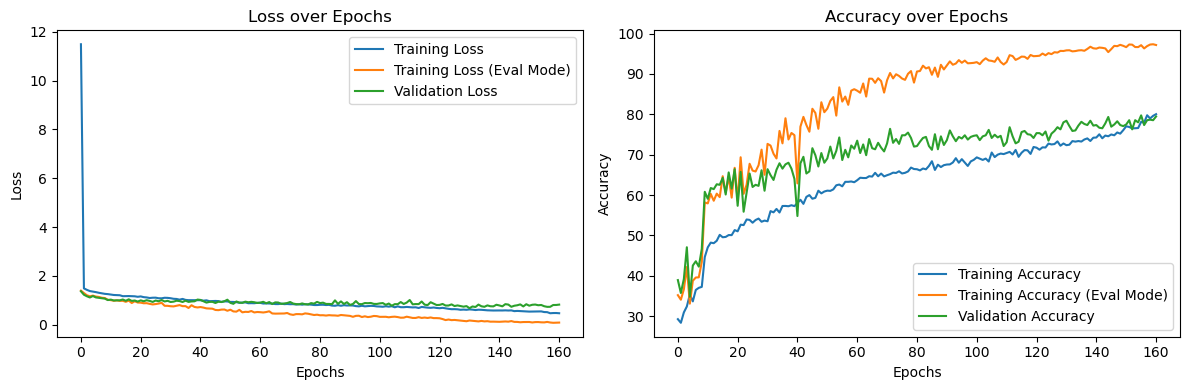

In [23]:
# Train the model and collect training history
trained_model, history = train_model_with_early_stopping2(model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS, patience=PATIENCE)

# Save training metrics to CSV
hyperparams = {
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'dropout': DROPOUT,
    'class_weights': CLASS_WEIGHTS.tolist(),
    'patience': PATIENCE
}
save_metrics_to_csv(history, os.path.join(RESULTS_DIR, 'training_metrics_2training_acc.csv'), hyperparams)

# Plot and save training and validation metrics
plot_metrics2(history, os.path.join(RESULTS_DIR, f'training_metrics_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_patience{PATIENCE}_classweights1-1-1-2-1.5.png'))


Training Set Evaluation:
Train Accuracy: 0.97
Train Precision: 0.97
Train Recall: 0.97
Train F1-Score: 0.97
Train Confusion Matrix:
[[1309    0   51   40    0]
 [   0 1358   11   26    5]
 [   3    0 1395    2    0]
 [   6    0   17 1377    0]
 [   0    0   19   19 1362]]

Validation Set Evaluation:
Validation Accuracy: 0.79
Validation Precision: 0.81
Validation Recall: 0.79
Validation F1-Score: 0.80
Validation Confusion Matrix:
[[114   1   8  25   2]
 [  1 133   1  11   4]
 [ 18   2 123   6   1]
 [  9   6  10 114  11]
 [  1   4   3  30 112]]

Test Set Evaluation:
Test Accuracy: 0.79
Test Precision: 0.80
Test Recall: 0.79
Test F1-Score: 0.79
Test Confusion Matrix:
[[111   5   6  25   3]
 [  1 137   2   6   4]
 [ 13   2 118  13   4]
 [ 11   7   5 115  12]
 [  2   4   6  27 111]]


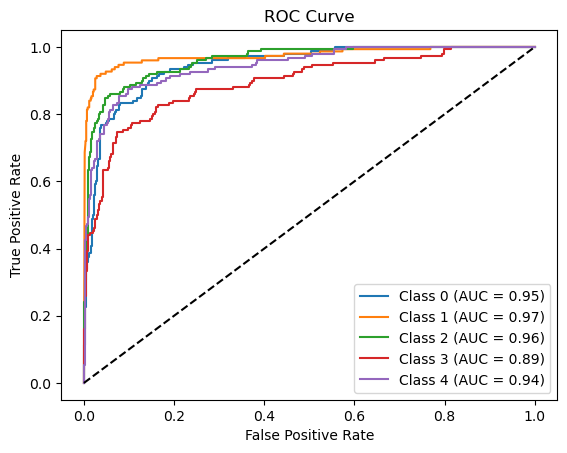

In [24]:
# Evaluate the model on the training set
print("\nTraining Set Evaluation:")
train_accuracy, train_precision, train_recall, train_f1, train_cm = evaluate_model(trained_model, train_loader, dataset_type="Train")

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(trained_model, val_loader, dataset_type="Validation")

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(trained_model, test_loader, dataset_type="Test")

# Plot and save ROC and AUC for the test set
plot_roc_auc(trained_model, test_loader, num_classes=NUM_CLASSES, save_path=os.path.join(RESULTS_DIR, f'roc_auc_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_patience{PATIENCE}_classweights1-1-1-2-1.5.png'))

# Save the trained model
save_model(trained_model, NUM_EPOCHS, os.path.join(MODELS_DIR, f'cnn_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_dropout{DROPOUT}_patience{PATIENCE}_classweights1-1-1-2-1.5.pth'), optimizer)

## 6.2. CNN with 4 Convolutional Layers, All with Padding

### 6.2.1. Execution 1

In [33]:
# Create data loaders
train_loader, val_loader, test_loader, mean, std = get_data_loaders(TRAIN_DIR, VAL_DIR, TEST_DIR, BATCH_SIZE)

# Initialize model
model = CNN2(num_classes=NUM_CLASSES)

# Initialize the weights
model.apply(weights_init)

# Define loss function 
CLASS_WEIGHTS = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0])  # Increase weight for the poorly performing class (i.e. staircase and movie theater)
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS.to(device))

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Epoch 0/199, Train Loss: 5.4305, Train Accuracy: 40.60, Train Loss (Eval Mode): 1.1353, Train Accuracy (Eval Mode): 55.54, Val Loss: 1.0543, Val Accuracy: 60.93
Epoch 1/199, Train Loss: 1.2293, Train Accuracy: 48.27, Train Loss (Eval Mode): 1.0096, Train Accuracy (Eval Mode): 60.86, Val Loss: 0.8983, Val Accuracy: 67.20
Epoch 2/199, Train Loss: 1.1704, Train Accuracy: 51.80, Train Loss (Eval Mode): 0.9922, Train Accuracy (Eval Mode): 60.57, Val Loss: 0.9507, Val Accuracy: 65.07
Epoch 3/199, Train Loss: 1.1599, Train Accuracy: 51.87, Train Loss (Eval Mode): 0.9184, Train Accuracy (Eval Mode): 64.24, Val Loss: 0.8389, Val Accuracy: 69.20
Epoch 4/199, Train Loss: 1.1019, Train Accuracy: 55.67, Train Loss (Eval Mode): 0.9225, Train Accuracy (Eval Mode): 64.76, Val Loss: 0.8850, Val Accuracy: 68.93
Epoch 5/199, Train Loss: 1.0487, Train Accuracy: 57.11, Train Loss (Eval Mode): 0.8337, Train Accuracy (Eval Mode): 68.14, Val Loss: 0.7895, Val Accuracy: 72.13
Epoch 6/199, Train Loss: 1.0348, T

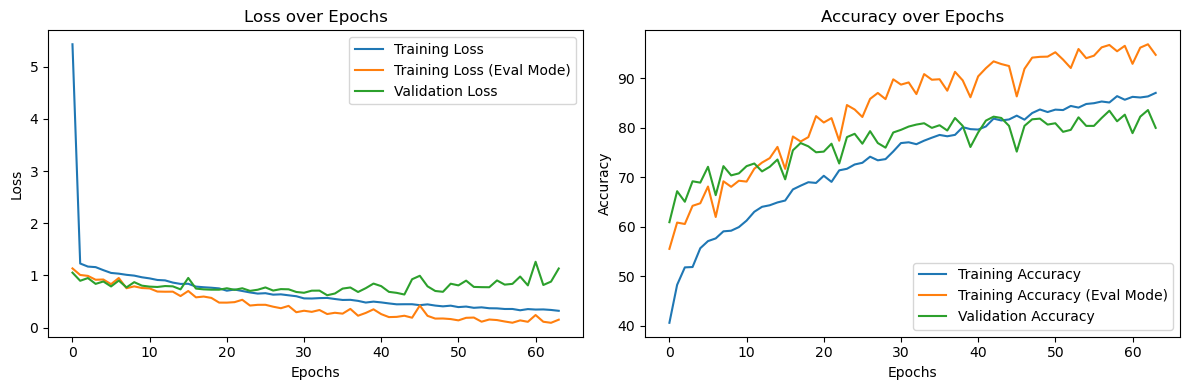

In [34]:
# Train the model and collect training history
trained_model, history = train_model_with_early_stopping2(model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS, patience=PATIENCE)

# Save training metrics to CSV
hyperparams = {
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'dropout': DROPOUT,
    'class_weights': CLASS_WEIGHTS.tolist(),
    'patience': PATIENCE
}
save_metrics_to_csv(history, os.path.join(RESULTS_DIR, 'training_metrics_cnn2.csv'), hyperparams)

# Plot and save training and validation metrics
plot_metrics2(history, os.path.join(RESULTS_DIR, f'training_metrics_cnn2_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_patience{PATIENCE}_classweights1-1-1-1-1.png'))


Training Set Evaluation:
Train Accuracy: 0.95
Train Precision: 0.95
Train Recall: 0.95
Train F1-Score: 0.95
Train Confusion Matrix:
[[1321    2    6   58   13]
 [   3 1370    1   21    5]
 [  13    0 1351   36    0]
 [  26   10   10 1235  119]
 [   4   10    8   22 1356]]

Validation Set Evaluation:
Validation Accuracy: 0.80
Validation Precision: 0.81
Validation Recall: 0.80
Validation F1-Score: 0.79
Validation Confusion Matrix:
[[115   2  17   8   8]
 [  1 136   4   3   6]
 [ 11   0 134   4   1]
 [ 13   6  11  77  43]
 [  1   1   5   5 138]]

Test Set Evaluation:
Test Accuracy: 0.80
Test Precision: 0.82
Test Recall: 0.80
Test F1-Score: 0.80
Test Confusion Matrix:
[[125   2   6   6  11]
 [  1 137   2   2   8]
 [  8   2 126   5   9]
 [ 17   9   9  77  38]
 [  3   2   6   1 138]]


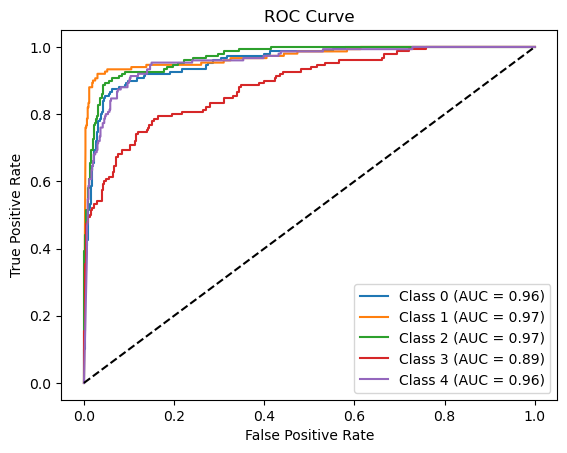

In [35]:
# Evaluate the model on the training set
print("\nTraining Set Evaluation:")
train_accuracy, train_precision, train_recall, train_f1, train_cm = evaluate_model(trained_model, train_loader, dataset_type="Train")

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(trained_model, val_loader, dataset_type="Validation")

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(trained_model, test_loader, dataset_type="Test")

# Plot and save ROC and AUC for the test set
plot_roc_auc(trained_model, test_loader, num_classes=NUM_CLASSES, save_path=os.path.join(RESULTS_DIR, f'roc_auc_cnn_2_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_patience{PATIENCE}_classweights1-1-1-1-1.png'))

# Save the trained model
save_model(trained_model, NUM_EPOCHS, os.path.join(MODELS_DIR, f'cnn2_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_dropout{DROPOUT}_patience{PATIENCE}_classweights1-1-1-1-1.pth'), optimizer)

In [38]:
summary(trained_model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
        MaxPool2d-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-14          [-1, 256,

### 6.2.2. Execution 2 (patience 25, weight decay = 1e-4, class weighting [1, 1, 1, 2, 1])

In [39]:
# Create data loaders
train_loader, val_loader, test_loader, mean, std = get_data_loaders(TRAIN_DIR, VAL_DIR, TEST_DIR, BATCH_SIZE)

# Initialize model
model = CNN2(num_classes=NUM_CLASSES)

# Initialize the weights
model.apply(weights_init)

# Define loss function 
CLASS_WEIGHTS = torch.tensor([1.0, 1.0, 1.0, 2.0, 1.0])  # Increase weight for the poorly performing class (i.e. staircase and movie theater)
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS.to(device))

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

Epoch 0/199, Train Loss: 5.6579, Train Accuracy: 30.59, Train Loss (Eval Mode): 1.3687, Train Accuracy (Eval Mode): 34.41, Val Loss: 1.3522, Val Accuracy: 36.40
Epoch 1/199, Train Loss: 1.3990, Train Accuracy: 33.94, Train Loss (Eval Mode): 1.2200, Train Accuracy (Eval Mode): 41.50, Val Loss: 1.1688, Val Accuracy: 47.20
Epoch 2/199, Train Loss: 1.3526, Train Accuracy: 35.29, Train Loss (Eval Mode): 1.1770, Train Accuracy (Eval Mode): 35.23, Val Loss: 1.1315, Val Accuracy: 38.00
Epoch 3/199, Train Loss: 1.3187, Train Accuracy: 35.94, Train Loss (Eval Mode): 1.1637, Train Accuracy (Eval Mode): 43.54, Val Loss: 1.0961, Val Accuracy: 46.93
Epoch 4/199, Train Loss: 1.2766, Train Accuracy: 35.99, Train Loss (Eval Mode): 1.1544, Train Accuracy (Eval Mode): 38.73, Val Loss: 1.1283, Val Accuracy: 39.47
Epoch 5/199, Train Loss: 1.2481, Train Accuracy: 37.97, Train Loss (Eval Mode): 1.1388, Train Accuracy (Eval Mode): 41.06, Val Loss: 1.0965, Val Accuracy: 44.40
Epoch 6/199, Train Loss: 1.2339, T

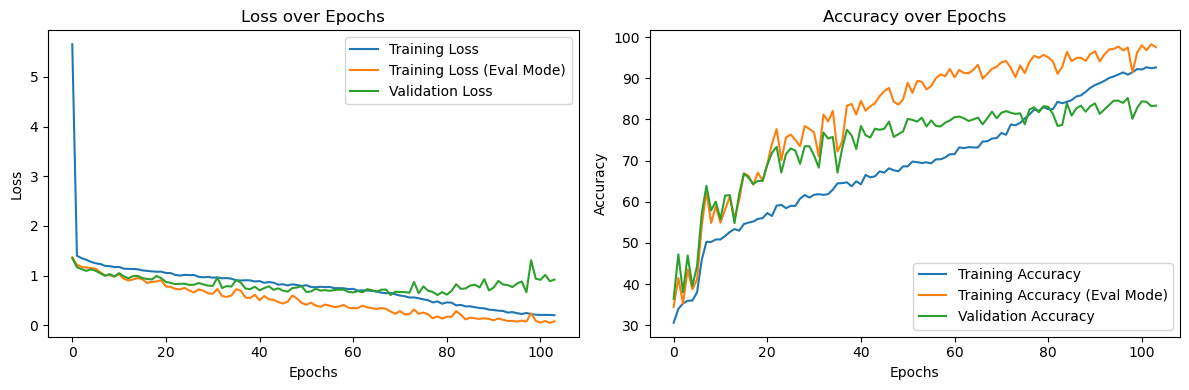

In [40]:
# Train the model and collect training history
trained_model, history = train_model_with_early_stopping2(model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS, patience=PATIENCE)

# Save training metrics to CSV
hyperparams = {
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'dropout': DROPOUT,
    'class_weights': CLASS_WEIGHTS.tolist(),
    'patience': PATIENCE,
    'weight_decay': 0.0001
}
save_metrics_to_csv(history, os.path.join(RESULTS_DIR, 'training_metrics_cnn2.csv'), hyperparams)

# Plot and save training and validation metrics
plot_metrics2(history, os.path.join(RESULTS_DIR, f'training_metrics_cnn2_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_patience{PATIENCE}_classweights1-1-1-2-1_weightdec1e-4.png'))

In [ ]:
# Evaluate the model on the training set
print("\nTraining Set Evaluation:")
train_accuracy, train_precision, train_recall, train_f1, train_cm = evaluate_model(trained_model, train_loader, dataset_type="Train")

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(trained_model, val_loader, dataset_type="Validation")

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(trained_model, test_loader, dataset_type="Test")

# Plot and save ROC and AUC for the test set
plot_roc_auc(trained_model, test_loader, num_classes=NUM_CLASSES, save_path=os.path.join(RESULTS_DIR, f'roc_auc_cnn_2_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_patience{PATIENCE}_classweights1-1-1-2-1_weightdec1e-4.png'))

# Save the trained model
save_model(trained_model, NUM_EPOCHS, os.path.join(MODELS_DIR, f'cnn2_bs{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{NUM_EPOCHS}_dropout{DROPOUT}_patience{PATIENCE}_classweights1-1-1-2-1_weightdec1e-4.pth'), optimizer)

# 7. Project Demo

## 7.1. Load the Best Model

In [25]:
def load_model(path, model_class, num_classes=NUM_CLASSES):
    """
    Load a trained model from a file.

    Inputs:
    - path (str): The file path to load the model from.
    - model_class (class): The class of the model to instantiate.
    - num_classes (int): Number of output classes.

    Outputs:
    - model (nn.Module): The loaded CNN model.
    - epoch (int): The epoch at which the model was saved.
    """
    start_time = time.time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_class(num_classes=num_classes)
    model = model.to(device)
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Model loaded in {time.time() - start_time:.2f} seconds.")
    return model, epoch

## 7.2. One Image Classification

### 7.2.1. Preprocess Chosen Image

In [26]:
def preprocess_image(image_path, mean, std):
    """
    Preprocess the input image for classification.

    Inputs:
    - image_path (str): Path to the input image.
    - mean (list): Mean for normalization.
    - std (list): Standard deviation for normalization.

    Outputs:
    - image (Tensor): Preprocessed image tensor.
    """
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image to 256x256
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize(mean=mean, std=std)  # Normalize the image
    ])
    
    image = Image.open(image_path).convert('RGB')  # Open the image and convert to RGB
    image = transform(image)  # Apply the transformations
    image = image.unsqueeze(0)  # Add a batch dimension
    return image

### 7.2.2. Classify Image

In [27]:
def classify_image(model, image):
    """
    Classify the input image using the trained model.

    Inputs:
    - model (nn.Module): The trained CNN model.
    - image (Tensor): Preprocessed image tensor.

    Outputs:
    - predicted_class (str): Predicted class label.
    - probability (float): Probability of the predicted class.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        image = image.to(device)
        outputs = model(image)
        probabilities = torch.softmax(outputs, dim=1)
        max_prob, predicted_label = torch.max(probabilities, 1)
        predicted_class = CLASSES[predicted_label.item()]
        probability = max_prob.item()

    return predicted_class, probability

### 7.2.3. Preprocess and Classify an Image

In [28]:
def preprocess_and_classify_image(model, mean, std, image_path):
    """
    Preprocess an image and classify it using the trained model.

    Inputs:
    - model (nn.Module): The trained CNN model.
    - mean (list): Mean for normalization.
    - std (list): Standard deviation for normalization.
    - image_path (str): Path to the input image.
    """
    print(f"Selected image: {image_path}")
    image = preprocess_image(image_path, mean, std)
    print("Image preprocessing complete.")
    predicted_class, probability = classify_image(model, image)
    print(f"Predicted Class: {predicted_class}, Probability: {probability:.4f}")

## 7.3. Classify a Test Sample

### 7.3.1. Generate a Test Sample

In [30]:
NO_CV_TEST_DIR = TEST_DIR
SAMPLE_TEST_DIR = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_dataset\processed_data\without_cross_validation\test_sample'

# Path settings
source_dir = NO_CV_TEST_DIR  # Path to the source directory, our without_cv's test
destination_dir = SAMPLE_TEST_DIR  # Path to the target directory
num_samples = 50  # Number of images to copy per category

# Ensure the target directory exists
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Iterate through each sub-folder in the source directory (each category)
for class_folder in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_folder)
    target_class_path = os.path.join(destination_dir, class_folder)

    # Create the target class folder if it does not exist
    if not os.path.exists(target_class_path):
        os.makedirs(target_class_path)

    # List all image files
    all_images = [file for file in os.listdir(class_path) if file.lower().endswith(('jpg'))]

    # Randomly select images
    selected_images = sample(all_images, num_samples)

    # Copy the selected images to the new location
    for image in selected_images:
        source_image_path = os.path.join(class_path, image)
        destination_image_path = os.path.join(target_class_path, image)
        shutil.copy(source_image_path, destination_image_path)


### 7.3.2. Classify All Images in a Test Sample Folder

In [54]:
from pathlib import Path

# Function to classify all images in a folder and its subfolders
def classify_all_images_in_folder(model, mean, std, base_folder):
    """
    Classify all images within a specified folder, including its subfolders.

    Inputs:
    - model (nn.Module): The trained CNN model.
    - mean (list): Mean values for normalization.
    - std (list): Standard deviation values for normalization.
    - base_folder (str): Path to the folder containing images organized in subfolders by class.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    total_images = 0
    total_correct = 0
    results = {}

    # Iterate over each sub-folder
    for class_folder in Path(base_folder).iterdir():
        if class_folder.is_dir():
            class_name = class_folder.name
            class_correct = 0
            class_total = 0

            # Iterate over all images in the class folder
            for image_file in class_folder.glob('*.jpg'):  
                image_path = str(image_file)
                predicted_class, probability = preprocess_and_classify_image(model, mean, std, image_path)

                # Update statistics
                class_total += 1
                if predicted_class == class_name:
                    class_correct += 1

            # Save results
            class_accuracy = class_correct / class_total if class_total > 0 else 0
            results[class_name] = {
                'accuracy': class_accuracy,
                'correct': class_correct,
                'total': class_total
            }
            total_correct += class_correct
            total_images += class_total

    total_accuracy = total_correct / total_images if total_images > 0 else 0
    results['total_accuracy'] = total_accuracy

    return results

## 7.4. Demo Execution

### 7.4.1. Best Model

In [ ]:
# Hyperparameters

BATCH_SIZE = 64
NUM_EPOCHS = 150
LEARNING_RATE = 0.001
DROPOUT = 0.6

CLASS_WEIGHTS = torch.tensor([1.0, 1.0, 1.0, 2.0, 1.0])
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)



In [32]:
# Create data loaders
train_loader, val_loader, test_loader, mean, std = get_data_loaders(TRAIN_DIR, VAL_DIR, TEST_DIR, BATCH_SIZE)

In [36]:
# Load the trained model
model_path = os.path.join(MODELS_DIR, 'best_model.pth')  # Replace with the actual model's filename
loaded_model, saved_epoch = load_model(model_path, CNN)

Model loaded in 1.14 seconds.


In [38]:
# Model architecture
summary(loaded_model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
        MaxPool2d-12          [-1, 128, 32, 32]               0
          Dropout-13          [-1, 128, 32, 32]               0
           Linear-14                  [

In [56]:
# Plot and save training and validation metrics
plot_metrics2(saved_epoch, os.path.join(RESULTS_DIR, f'best_model_loss_acc_over_epochs.png'))

TypeError: 'int' object is not subscriptable

In [42]:
# Evaluate the model on the training set
print("\nTraining Set Evaluation:")
train_accuracy, train_precision, train_recall, train_f1, train_cm = evaluate_model(load_model, train_loader, dataset_type="Train")

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(load_model, val_loader, dataset_type="Validation")

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(loaded_model, test_loader, dataset_type="Test")

# Plot and save ROC and AUC for the test set
plot_roc_auc(trained_model, test_loader, num_classes=NUM_CLASSES, save_path=os.path.join(RESULTS_DIR, f'roc_auc_best_model.png'))


Training Set Evaluation:


AttributeError: 'function' object has no attribute 'to'

In [ ]:
# Individual class metrics
print_class_metrics(loaded_model, train_loader)
print_class_metrics(loaded_model, val_loader)
print_class_metrics(loaded_model, test_loader)

### 7.4.2. Single Image Classification

In [43]:
# Chosen image path
image_path = r"C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\original\places365_standard\val\airplane_cabin\Places365_val_00003919.jpg"

# Classify an image using the loaded model
preprocess_and_classify_image(loaded_model, MEAN, STD, image_path)

Selected image: C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\original\places365_standard\val\airplane_cabin\Places365_val_00003919.jpg
Image preprocessing complete.
Predicted Class: airplane_cabin, Probability: 1.0000


In [44]:
print(preprocess_image(image_path, mean, std))

tensor([[[[-0.0560, -0.0560, -0.0720,  ...,  0.6497,  0.6658,  0.6658],
          [ 0.0242, -0.0079, -0.0720,  ...,  0.6177,  0.5856,  0.6337],
          [-0.2966, -0.2485, -0.1683,  ...,  0.7460,  0.9224,  0.9385],
          ...,
          [-1.7562, -1.7562, -1.7562,  ..., -1.1948, -1.4515, -1.7722],
          [-1.7562, -1.7562, -1.7562,  ..., -1.3231, -1.5958, -1.7241],
          [-1.7562, -1.7562, -1.7562,  ..., -1.4996, -1.7722, -1.6600]],

         [[-0.0089, -0.0089, -0.0253,  ...,  0.7912,  0.8075,  0.8075],
          [ 0.1054,  0.0727,  0.0074,  ...,  0.7586,  0.7259,  0.7749],
          [-0.1722, -0.1233, -0.0416,  ...,  0.8892,  1.0688,  1.0852],
          ...,
          [-1.6256, -1.6256, -1.6256,  ..., -1.0540, -1.3153, -1.6419],
          [-1.6256, -1.6256, -1.6256,  ..., -1.1847, -1.4623, -1.5929],
          [-1.6256, -1.6256, -1.6256,  ..., -1.3643, -1.6419, -1.5276]],

         [[ 0.2579,  0.2579,  0.2412,  ...,  0.9763,  0.9930,  0.9930],
          [ 0.3581,  0.3247,  

### 7.4.3. Test Sample Classification

In [55]:
# Define the path of the sample images‘ folder 
base_folder = SAMPLE_TEST_DIR

# Classify all images and return the results
results = classify_all_images_in_folder(loaded_model, MEAN, STD, base_folder)

# Print the results
for class_name, info in results.items():
    if class_name != 'total_accuracy':
        print(f"Accuracy for {class_name}: {info['accuracy'] * 100:.2f}% ({info['correct']}/{info['total']})")
print(f"Total accuracy across all classes: {results['total_accuracy'] * 100:.2f}%")

Selected image: C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_dataset\processed_data\without_cross_validation\test_sample\airplane_cabin\00000126.jpg
Image preprocessing complete.
Predicted Class: airplane_cabin, Probability: 1.0000


TypeError: cannot unpack non-iterable NoneType object